In [ ]:
import rtde_control
import rtde_receive
import numpy as np
import sys
import yaml
from matplotlib import pyplot as plt
import SimpleITK as sitk
import pickle as pkl


import pyrealsense2 as rs
import cv2
import torch
import time
from collections import deque


from force_control import z_force_control
from slice_matching import global_match,local_match


from img_utils import get_slice_at, flip_img, getVesselBox

sys.path.append("../../")

from scripts.Registration3D.registration import central_normalize_img, calculate_ct2us_transform
from scripts.SurfaceContact.move import move_default_pose

from scripts.SurfaceContact.control import SurfaceContactControl
from scripts.USImageCV.models.unet import UNet
from scripts.USImageCV.utils.bunny import bunny_mask_predict, load_bunny_model,max_connected_area
%load_ext autoreload
%autoreload 2

# Connect to robot

In [2]:
# from recording_upload_server import CaptureServer

rtde_c = rtde_control.RTDEControlInterface("192.168.1.2")
rtde_r = rtde_receive.RTDEReceiveInterface("192.168.1.2")


# Connect to ultrasound image stream

In [3]:
ultrasound_vid = cv2.VideoCapture('/dev/video8')

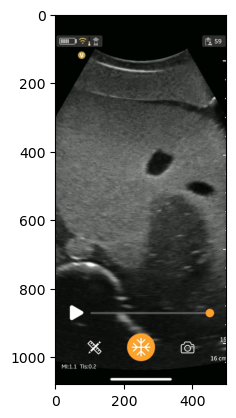

In [4]:

ret, frame = ultrasound_vid.read()		
plt.imshow(frame)

# Load pre-trained bunny segmentation model

In [5]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

trunk_model = load_bunny_model('../../scripts/USImageCV/model_weights/trunk_seg_model.pth',device)
vessel_model = load_bunny_model('../../scripts/USImageCV/model_weights/vessel_model.pth',device)

# Connect to RGB-D Camera

In [6]:
pipeline = rs.pipeline()
pipeline.start()


# Initialize surface finding controller

In [7]:
with open('../../config/pose_in_TCP_frame.yaml','r') as f:
    poses = yaml.safe_load(f)

    camera_2_tcp = poses['camera']
    probe_2_tcp = poses['probe']
    
body_color_rgb = (99, 55, 34)
body_hsv_rad = (50,50,200)
# rtde_c = rtde_r = []
sc = SurfaceContactControl(pipeline,rtde_c,rtde_r,
                           camera_2_tcp,probe_2_tcp,
                           body_color_rgb,body_hsv_rad)

In [9]:
move_default_pose(rtde_c)

376 382


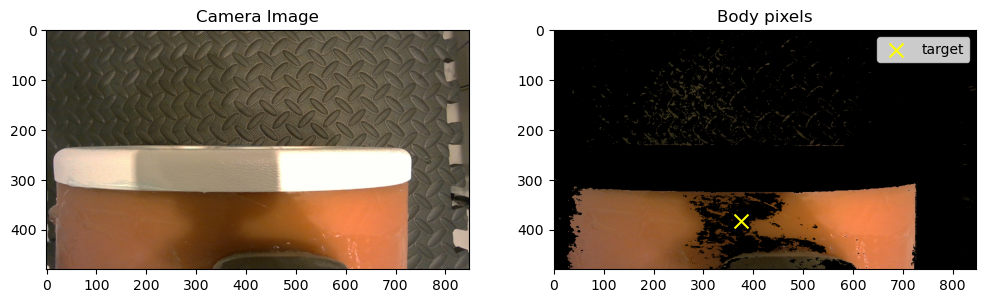

In [8]:
sc.fetchCameraStreamData()
fig = plt.figure(dpi=100,figsize = (12,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
sc.showScene([ax1,ax2])


# Probe Control functions

In [23]:

def find_surface(sc):
    for _ in range(40):
        dist = sc.mainloop()
        dist_threshold = 0.005
        if dist<dist_threshold:
            break
    print("Arrived at above target location. Start descending.")

    sc.loc_normal_control(hover_height=0.20)
    # s = input("Find surface:?")

    if sc.getContact():
        print("Contact made.")


def find_object(model,area_threshold=5000):
    '''
        model: a neural network that detects the pixels of the object to find.
    '''

    def view_optim(start_pose,target_pose,
                   search_vel=0.001,search_acc=0.1):
        # Optimize the view by traversing the robot from a start pose to a goal pose.

        # Move the TCP to the starting pose.
        rtde_c.moveL(start_pose,0.01,0.1) 
        
        # After reaching the starting pose, fire off the TCP to move towards the target_pose.
        # Setting asynchoronous=True allows the code to fly forward while the robot execute the motion independently.
        rtde_c.moveL(target_pose,search_vel,search_acc,asynchronous=True) 
        
        # In the asynchorous mode of moveL, we have to actively monitor the robot speed to determine whether the robot has stopped.
        speeds = []

        time.sleep(0.01) # This will allow the robot to start moving a little
        area_diff = deque(maxlen=3)

        max_area = 0
        optim_pose = []
        frames = []
        for i in range(1000):
            linear_tcp_speed = np.linalg.norm(rtde_r.getActualTCPSpeed()[:3])
            speeds.append(linear_tcp_speed)
            
            ret, frame = ultrasound_vid.read()	
            frames.append(frame)
            ###### Must record the curr_pose right after the image read and before the neural network inference.
            curr_pose = rtde_r.getActualTCPPose()	
            ######


            mask = bunny_mask_predict(model,frame,device)
            area = max_connected_area(mask)
            # print("area",area,"Time elapsed:",time.time()-start_time)
            area_diff.append(area)
            
            if area>max_area:
                max_area = area
                optim_pose = curr_pose
            
            if len(area_diff)>=3 and\
                np.min(area_diff)>4000 and \
                    area_diff[-1]-area_diff[-2]<0 and area_diff[-2]-area_diff[-3]<0:
                # If the area starts to consistently decline, stop the robot. 
                # print(list(area_diff))
                rtde_c.stopL() 
                # We can call stopL() to manually stop the robot during execution.
                # This is very useful pairing with the async move of moveL.

                # And move the robot to the optimal pose
                rtde_c.moveL(optim_pose,0.01,0.1)

                return max_area,frames
    
        if linear_tcp_speed<1e-4:
            return max_area,frames
    

    def y_direction_search():
        # y direction search has to be very careful, with low speed vel=0.001
        tcp_pose = rtde_r.getActualTCPPose()

        start_pose = rtde_c.poseTrans(tcp_pose,[0,-0.03,0,0,0,0])

        target_pose = rtde_c.poseTrans(tcp_pose,[0,+0.03,0,0,0,0])

        return view_optim(start_pose,target_pose,
                            search_vel = 0.01,
                            search_acc = 0.1)

    def x_direction_search():
        # x direction search can be more crude, with intermediate speed vel=0.01
        tcp_pose = rtde_r.getActualTCPPose()

        start_pose = rtde_c.poseTrans(tcp_pose,[-0.05,0,0,0,0,0])

        target_pose = rtde_c.poseTrans(tcp_pose,[+0.05,0,0,0,0,0])

        return view_optim(start_pose,target_pose,
                            search_vel = 0.01,
                            search_acc = 0.1)
    max_a = 0
    while True:
        y_direction_search()
        
        a,_ = x_direction_search()
        print('Max area',a)
        if a>=max_a:
            max_a = a
        if max_a>=area_threshold:
            break


def centralize_object(model):
    '''
        model: the neural network responsible for outputing the segmentation mask of the desired object.
    '''
    for i in range(20):
        ret, frame = ultrasound_vid.read()	
        mask = bunny_mask_predict(model,frame,device)
        z_c,x_c=np.mean(np.argwhere(mask),axis=0)

        # We have ensured that the x axis of TCP aligns with axis 1 of frame, and z axis of TCP aligns with axis[0] of frame.
        x_dir = x_c-frame.shape[1]//2
        print("Centralizing the object. Pixel distance remaining: ",np.linalg.norm(x_dir))

        if np.linalg.norm(x_dir)<20:
            break

        tcp_pose = rtde_r.getActualTCPPose()

        move_step = 1/100
        target_pose = rtde_c.poseTrans(tcp_pose,[move_step*np.sign(x_dir),0,0,0,0,0])


        rtde_c.moveL(target_pose,0.005,0.1)
    

def record_registration(model,n_samples):
    def record(start_pose,target_pose, n_waypoints = 50):
        start_loc = start_pose[:3]
        target_loc = target_pose[:3]
        waypoints = np.linspace(start_loc,target_loc,n_waypoints)
        waypoints = [list(w)+start_pose[3:] for w in waypoints]

        rtde_c.moveL(start_pose,0.01,0.1)
        # y direction search has to be very careful, with low speed vel=0.001
        tcp_pose = rtde_r.getActualTCPPose()
        start_pose = tcp_pose

        # In the asynchorous mode of moveL, we have to actively monitor the robot speed to determine whether the robot has stopped.
        speeds = []
        start_time = time.time()

        time.sleep(0.01) # This will allow the robot to start moving a little
        n_hist = 5
        areas = deque(maxlen=n_hist)

        poses=[]
        frames = []
        for w in waypoints:
            
            ret, frame = ultrasound_vid.read()
            frames.append(frame)
            ###### Must record the curr_pose right after the image read and before the neural network inference.
            curr_pose = rtde_r.getActualTCPPose()	
            poses.append(curr_pose)
            ######
            mask = bunny_mask_predict(model,frame,device)
            area = max_connected_area(mask)
            print("area",area,"Time elapsed:",time.time()-start_time)
            areas.append(area)
            if len(areas)>=n_hist and np.max(areas)<=2000:
                # If the area starts to consistently be small, stop the robot.
                # And move the robot to the start pose
                break
            rtde_c.moveL(w,0.01,0.1)
        rtde_c.moveL(start_pose,0.01,0.1)
        return frames,poses
    start_pose = rtde_r.getActualTCPPose()
    frames = []
    poses = []
    
    # Move and record in the feet direction
    target_pose = rtde_c.poseTrans(start_pose,[0,-0.03,0,0,0,0])
    f,p = record(start_pose,target_pose,n_waypoints = n_samples//2)
    
    # Make sure the order is from feet towards head
    f.reverse()
    p.reverse()

    frames+=f
    poses+=p
    # Move and record in the head direction
    target_pose = rtde_c.poseTrans(start_pose,[0,0.03,0,0,0,0])
    f,p = record(start_pose,target_pose,n_waypoints = n_samples//2)
    frames+=f
    poses+=p
    return frames,poses



def slice_matching_control(vessel_ct_slice,us_spacing,mode='global'):
    def search(y_step,n_iter = 20,lookback = 3):

        max_am = 0
        prev_am = None
        max_pos = rtde_r.getActualTCPPose()

        score_deque = deque(maxlen=lookback)
        diff_deque = deque(maxlen=lookback)
        for _ in range(n_iter):
            ret, frame = ultrasound_vid.read()
            pred_mask = bunny_mask_predict(vessel_model,frame,device)
            vessel_us_slice = pred_mask.T
            vessel_us_slice = sitk.GetImageFromArray(vessel_us_slice)
            vessel_us_slice.SetSpacing(us_spacing)

            t = time.time()
            if mode == 'global':
                _,am = global_match(vessel_ct_slice,vessel_us_slice)
            else:
                _,am = local_match(vessel_ct_slice,vessel_ct_slice)
            print("Local match elapsed:",time.time()-t,"Match score:",am)

            curr_pose = rtde_r.getActualTCPPose()
            if am>max_am:
                max_pos = curr_pose
                max_am = am


            if prev_am is not None:
                diff_deque.append(am-prev_am)
            
            prev_am = am

            if len(diff_deque)>=lookback and np.max(diff_deque)<0:
                break
            
            score_deque.append(am)
            if len(score_deque)>=lookback and np.max(score_deque)<100:
                break
            
            next_pose = rtde_c.poseTrans(curr_pose,[0,y_step,0,0,0,0])
            rtde_c.moveL(next_pose,0.01,0.1)
            centralize_object(vessel_model)
            
        return max_am, max_pos
    
            
    initial_pos = rtde_r.getActualTCPPose()

    

    step = 1/1000
    max_am,max_pos = search(step)

    rtde_c.moveL(initial_pos,0.01,0.1)

    step = -1/1000
    a,p = search(step)

    if a>max_am:
        max_pos = p
        max_am = a
    rtde_c.moveL(max_pos,0.01,0.1)
    return max_pos


In [13]:
# Start the control pipeline
move_default_pose(rtde_c)

In [14]:
# Start the control pipeline
move_default_pose(rtde_c)
w0 = rtde_r.getActualTCPForce()# Record force zero

find_surface(sc)

Arrived at above target location. Start descending.
Contact made.


In [15]:
target_force = 20
force_err_tolerance = 0.2
z_force_control(target_force,rtde_r,rtde_c,w0)

Current force is:1.1426709927928904:  Time elapsed=00:00

Current force is:19.880333412639306:  Time elapsed=00:11

Target force reached.


True

In [16]:
find_object(trunk_model)
centralize_object(trunk_model)
trunk_pos = rtde_r.getActualTCPPose()
with open('trunk_pos.pkl','wb') as fp:
    pkl.dump(trunk_pos,fp)

Max area 8513.0
Centralizing the object. Pixel distance remaining:  22.708963778083444
Centralizing the object. Pixel distance remaining:  7.7198399085191625


In [17]:

f,p = record_registration(vessel_model,n_samples=80)

with open('registration_3d_frames.pkl','wb') as fp:
    pkl.dump({'frames':f,'waypoints':p},fp)

area 8069.0 Time elapsed: 0.47847867012023926
area 8005.0 Time elapsed: 0.9467742443084717
area 8037.0 Time elapsed: 1.6205556392669678
area 8253.0 Time elapsed: 2.2759485244750977
area 8600.0 Time elapsed: 2.798083543777466
area 9052.0 Time elapsed: 3.4118034839630127
area 9417.0 Time elapsed: 3.990291118621826
area 9868.0 Time elapsed: 4.538519382476807
area 17796.0 Time elapsed: 5.154040575027466
area 18853.0 Time elapsed: 5.767340421676636
area 19045.0 Time elapsed: 6.3911826610565186
area 10702.0 Time elapsed: 6.9886720180511475
area 9594.0 Time elapsed: 7.605122804641724
area 8647.0 Time elapsed: 8.22533917427063
area 7983.0 Time elapsed: 8.843838691711426
area 8138.0 Time elapsed: 9.456024408340454
area 8174.0 Time elapsed: 10.077484369277954
area 5825.0 Time elapsed: 10.707903146743774
area 5968.0 Time elapsed: 11.349978923797607
area 5992.0 Time elapsed: 12.0089750289917
area 5769.0 Time elapsed: 12.699056625366211
area 5553.0 Time elapsed: 13.354310512542725
area 5665.0 Time 

In [18]:

with open('registration_3d_frames.pkl','rb') as fp:
    reg_data = pkl.load(fp)

frames,waypoints = reg_data['frames'],reg_data['waypoints']

masks = []
for frame in frames:
    masks.append(bunny_mask_predict(vessel_model,frame,device))
masks = np.array(masks)

# Get rid of the noisy predictions in the image. Only save the maximal connected component
_,masks = max_connected_area(masks,return_mask=True)

vessel_us = sitk.GetImageFromArray(masks)
with open('../../config/us_spacing.yaml') as fp:
    sp = yaml.safe_load(fp)

# Spacing Units are mm.
xspacing = sp['xspacing'] 
yspacing = sp['yspacing']
start_loc = np.array(waypoints[0][:3])
end_loc = np.array(waypoints[-1][:3])
zspacing = 1000*np.linalg.norm(start_loc-end_loc)/len(f)

vessel_us.SetSpacing((xspacing,yspacing,zspacing))

# Save checkpoint for registration
sitk.WriteImage(vessel_us,'./nifty/vessel_us.nii.gz')

# 3D Registration between US and CT

In [10]:


original_vessel_ct = sitk.ReadImage('./nifty/vessel_ct.nii.gz')
# The left-right order is different between the US image and CT image. We flip vessel_ct to make them consistent.
original_vessel_ct = flip_img(original_vessel_ct,[True,False,False])
vessel_ct = central_normalize_img(original_vessel_ct,150)



original_vessel_us = sitk.ReadImage('./nifty/vessel_us.nii.gz')
vessel_us = central_normalize_img(original_vessel_us,150)

CT2US = calculate_ct2us_transform(vessel_us,vessel_ct)

Start optimizing the transformation


100%|██████████| 10/10 [00:49<00:00,  4.90s/it]


In [12]:
with open('CT2US.pkl','wb') as fp:
    pkl.dump(CT2US,fp)

In [10]:
with open('CT2US.pkl','rb') as fp:
    CT2US = pkl.load(fp)

# Select a list of locations in CT and move the robots to go to them

In [13]:
del original_vessel_ct,original_vessel_us

In [26]:

def move_horizontal_record(target_loc_ct,us_origin,direction = 'left-right'):

    def move_xy(ref_pos,rtde_r,rtde_c):
        tcp = rtde_r.getActualTCPPose()
        target_pose = ref_pos[:2]+tcp[2:]
        return rtde_c.moveL(target_pose,0.03,0.1)

    target_loc_us = CT2US.TransformPoint(target_loc_ct)
    tx = -target_loc_us[-1]/1000
    ty = -target_loc_us[0]/1000
    us_x = us_origin[0]
    us_y = us_origin[1]
    curr_pose = rtde_r.getActualTCPPose()

    # x-axis in robot base frame = head-feet axis in CT frame
    # y-axis in robot base frame = left-right axis in CT frame
    if direction=='left-right':
        target_loc_robot = [curr_pose[0],us_y+ty,0,0,0,0]
    elif direction == 'head-feet':
        target_loc_robot = [us_x+tx,curr_pose[1],0,0,0,0]
    move_xy(target_loc_robot,rtde_r,rtde_c)
    time.sleep(0.3)
    ret,frame = ultrasound_vid.read()
    return frame

In [15]:
from scripts.Registration3D.registration import visualize_vessel,get_centroid_loc


body_ct = sitk.ReadImage('./nifty/CT_phantom_regular.nii.gz')
body_ct = flip_img(body_ct,[True,False,False])
vessel_ct = sitk.ReadImage('./nifty/vessel_ct.nii.gz')
vessel_ct = flip_img(vessel_ct,[True,False,False])


with open('../../config/us_spacing.yaml') as fp:
    sp = yaml.safe_load(fp)
# Spacing Units are mm. 
us_spacing = (sp['xspacing'], sp['yspacing'])

with open('registration_3d_frames.pkl','rb') as fp:
    data = pkl.load(fp)

original_vessel_us = sitk.ReadImage('./nifty/vessel_us.nii.gz')
waypoints = data['waypoints']
probe_pos_0 = rtde_c.poseTrans(waypoints[0],sc.probe_2_tcp)
us_origin = rtde_c.poseTrans(probe_pos_0,[-original_vessel_us.GetSpacing()[0]*original_vessel_us.GetSize()[0]/(2*1000),0,0,0,0,0])



x_cand = [-80,-40,-20,0,20]
z_cand = [-10,-5,0,5,10]

target_locs = [ get_centroid_loc(vessel_ct) + np.array([x,0,z]) for x in x_cand for z in z_cand]

us_shape = original_vessel_us.GetSize()[:2]
del original_vessel_us,data

In [12]:
with open('trunk_pos.pkl','rb') as fp:
    trunk_pos = pkl.load(fp)

In [13]:
rtde_c.moveL(trunk_pos,0.05,0.1)

True

In [42]:
move_default_pose(rtde_c)

In [29]:

observations = []
probe_poses = []
local_match_max_pixel_threshold = 200

for loc in target_locs[:]:

    pix = vessel_ct.TransformPhysicalPointToIndex(loc)
   
    print('Create vessel_ct_slice')
    # Standardize the resolution for US and CT vessel slice images.
    h,w = np.array(us_shape)*np.array(us_spacing)/np.array(vessel_ct_slice.GetSpacing())
    vessel_ct_slice = getVesselBox(body_ct,vessel_ct,pix,w,h)
    matching_mode = 'local'
    
    if np.sum(vessel_ct_slice)<local_match_max_pixel_threshold:
        vessel_ct_slice = get_slice_at(vessel_ct,pix) # If there is not enough IVC pixels seen in the target box, use the full slice as the fixed image.
        matching_mode = 'global'


    vessel_ct_slice = sitk.GetImageFromArray(vessel_ct_slice)
    vessel_ct_slice.SetSpacing(vessel_ct.GetSpacing()[:2])

    print('Slice matching contronl starts')
    rtde_c.moveL(trunk_pos,0.05,0.1)
    move_horizontal_record(loc,us_origin,direction='head-feet')
    slice_matching_pos = slice_matching_control(vessel_ct_slice,us_spacing,mode = matching_mode)
    
    # print('Move horizontal')
    frame = move_horizontal_record(loc,us_origin)
    observations.append(frame)
    probe_poses.append(rtde_r.getActualTCPPose())
    

Calculate loc_us
Create vessel_ct_slice
Slice matching contronl starts
Local match elapsed: 0.30405139923095703 Match score: 168.9529
Centralizing the object. Pixel distance remaining:  117.62658444672832
Centralizing the object. Pixel distance remaining:  71.2634400126123
Centralizing the object. Pixel distance remaining:  13.578938385390018
Local match elapsed: 0.2827773094177246 Match score: 176.5046
Centralizing the object. Pixel distance remaining:  6.082230311052285
Local match elapsed: 0.3199186325073242 Match score: 193.2044
Centralizing the object. Pixel distance remaining:  1.9376528117359442
Local match elapsed: 0.31825923919677734 Match score: 204.27689
Centralizing the object. Pixel distance remaining:  7.547831001836926
Local match elapsed: 0.2306985855102539 Match score: 204.02986
Centralizing the object. Pixel distance remaining:  16.103302976756822
Local match elapsed: 0.3050563335418701 Match score: 194.20815
Centralizing the object. Pixel distance remaining:  23.6326

KeyboardInterrupt: 

In [20]:
max_pos = rtde_r.getActualTCPPose()

In [30]:
# Save the observations
with open('us_observations.pkl','wb') as fp:
    pkl.dump({'frame':observations,'probe_pose':probe_poses,'CT_target_locs':target_locs[:len(observations)],'CT_image':vessel_ct,'Observation Origin':get_centroid_loc(vessel_ct)},fp)

1.0 0.0


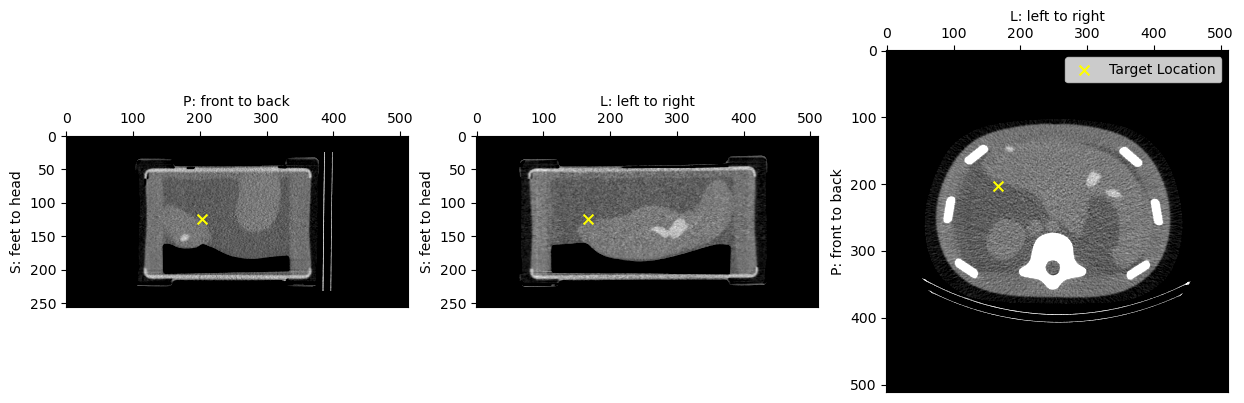

1.0 0.0


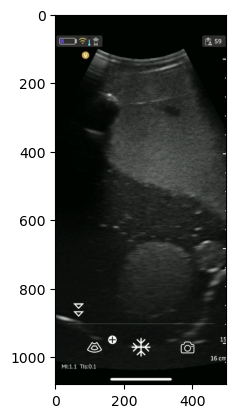

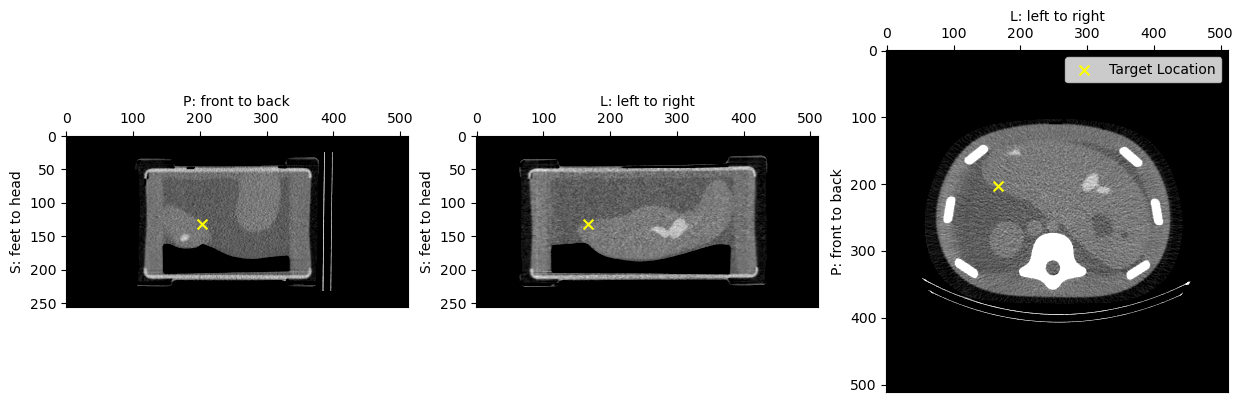

1.0 0.0


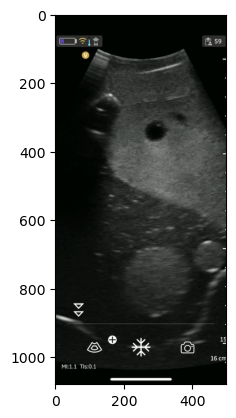

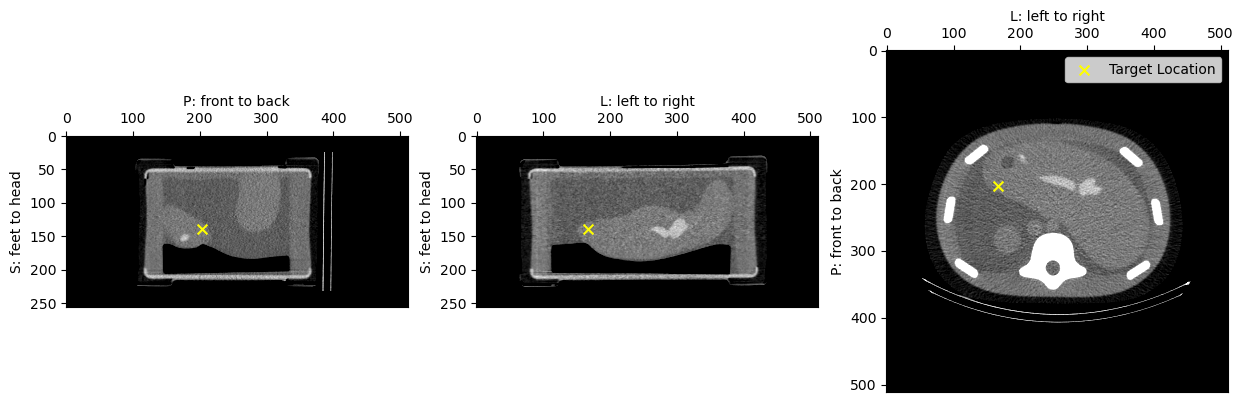

1.0 0.0


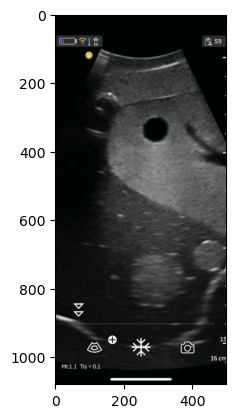

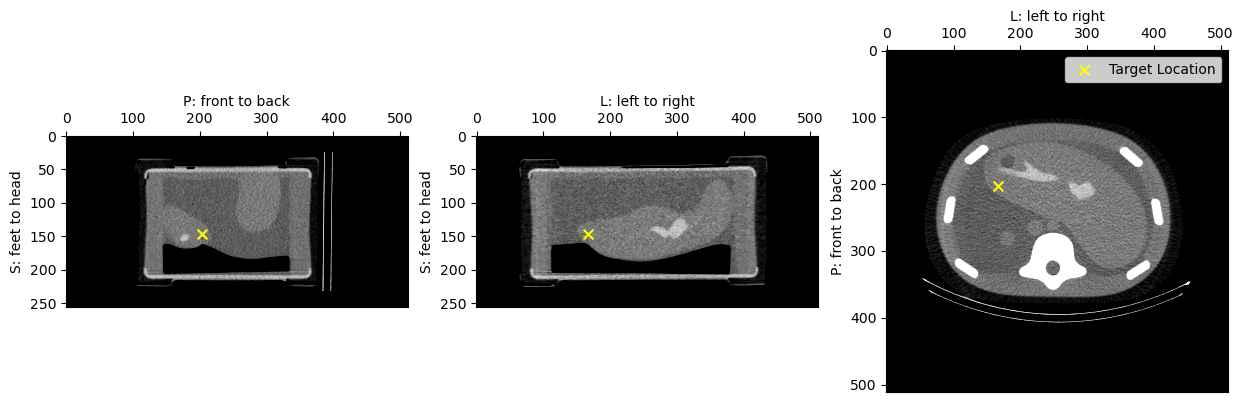

1.0 0.0


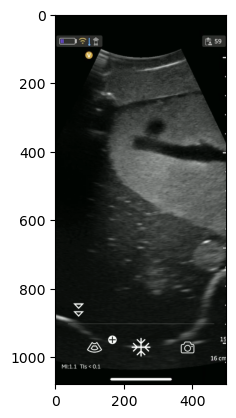

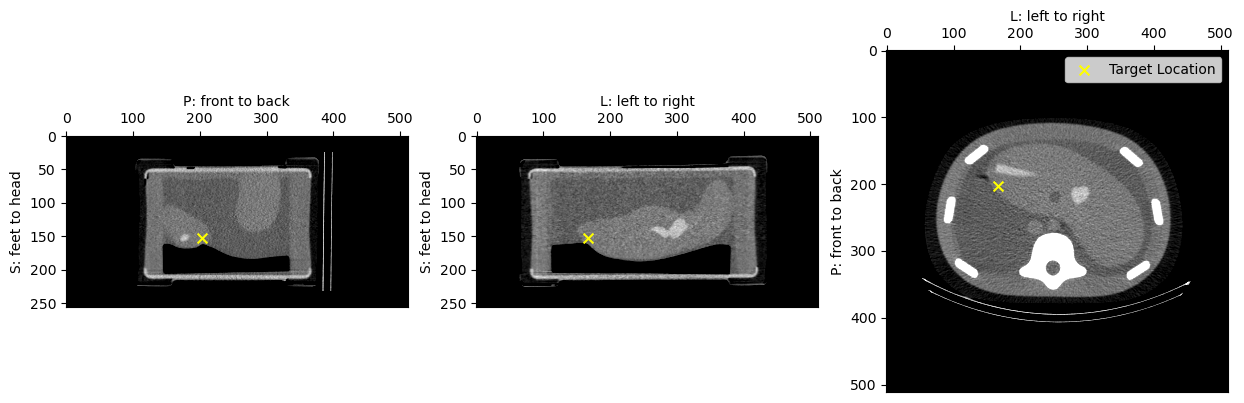

1.0 0.0


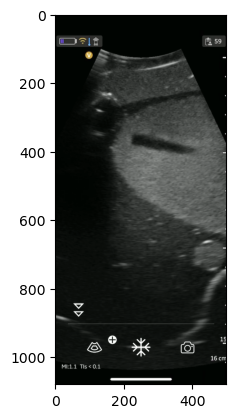

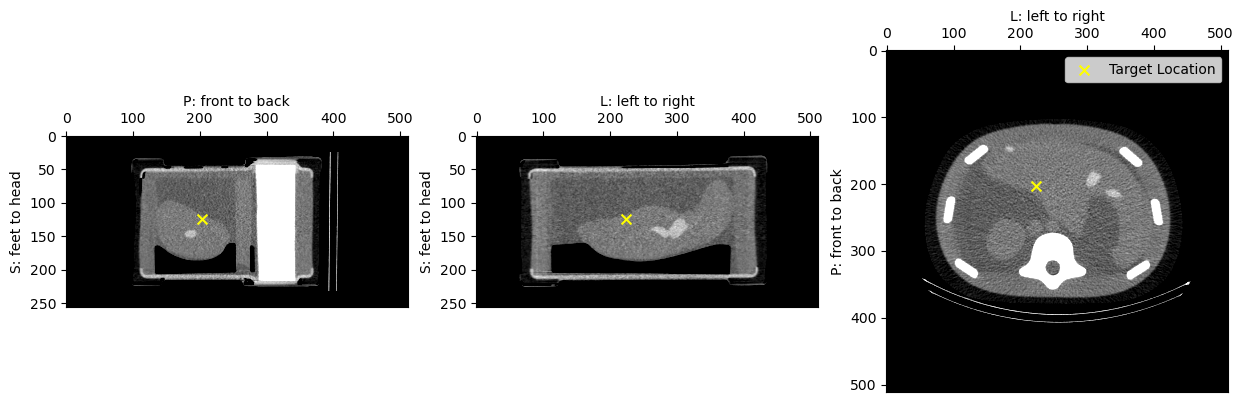

1.0 0.0


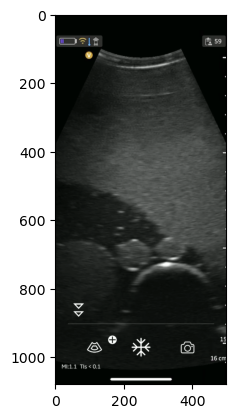

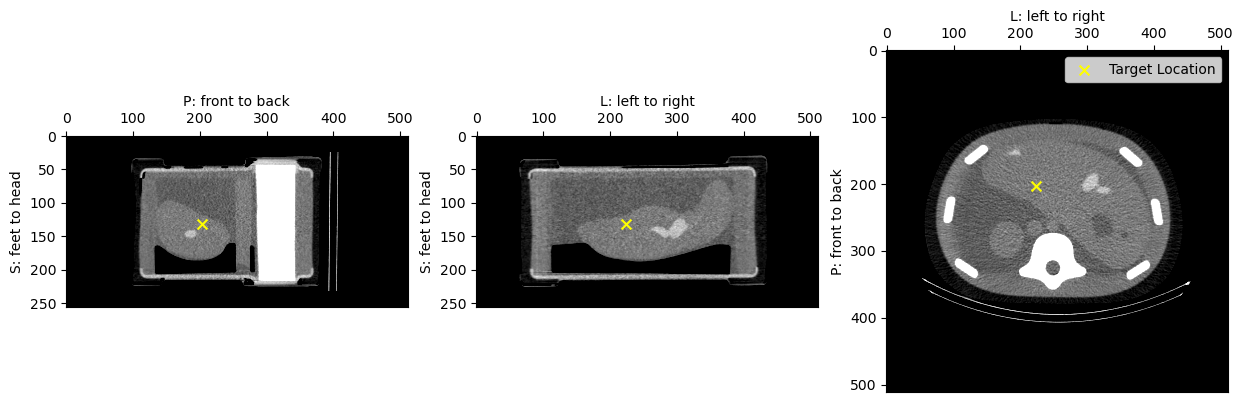

1.0 0.0


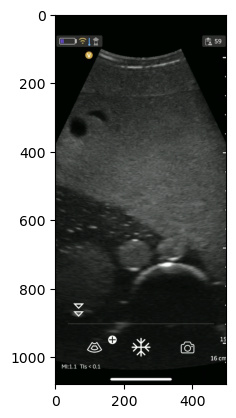

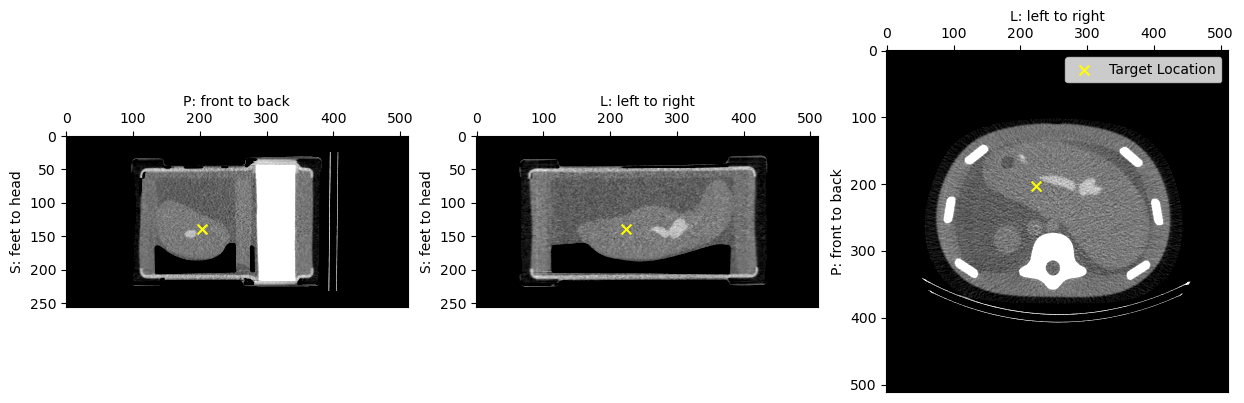

1.0 0.0


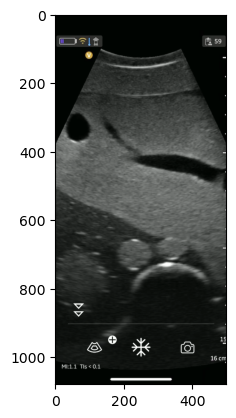

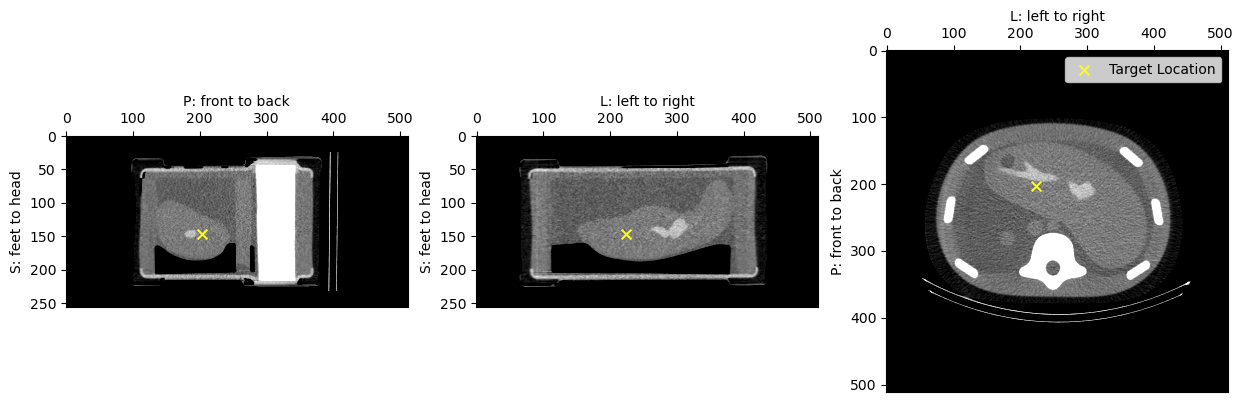

1.0 0.0


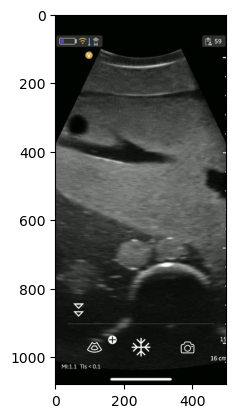

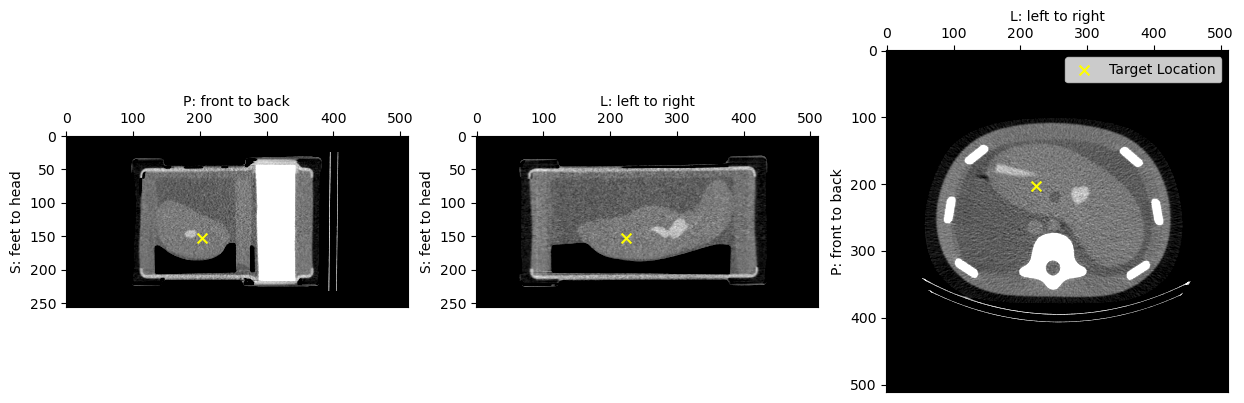

1.0 0.0


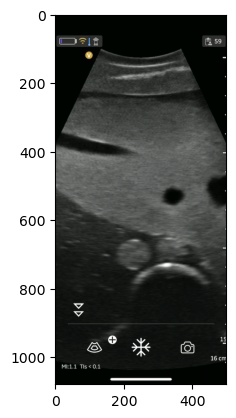

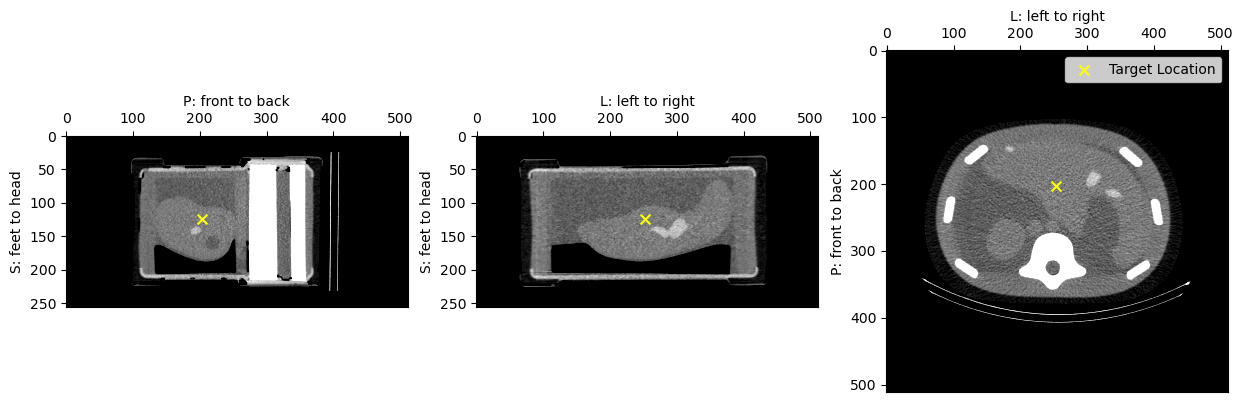

1.0 0.0


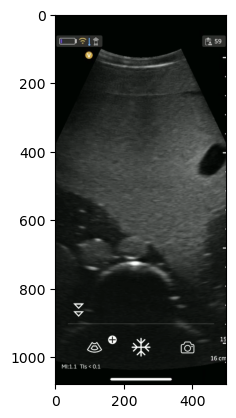

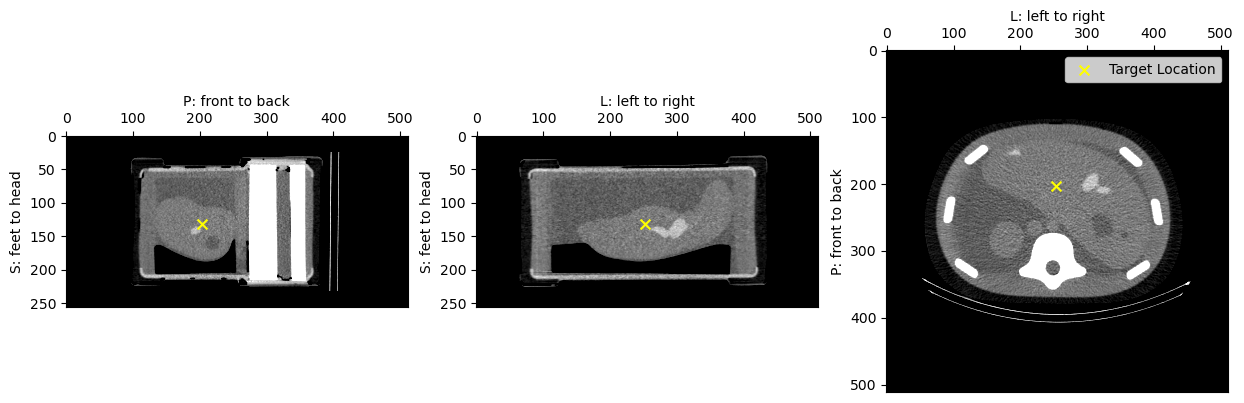

1.0 0.0


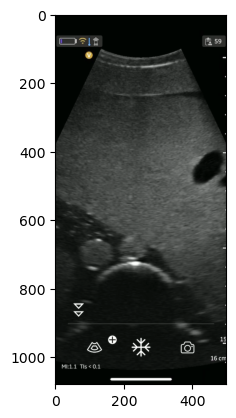

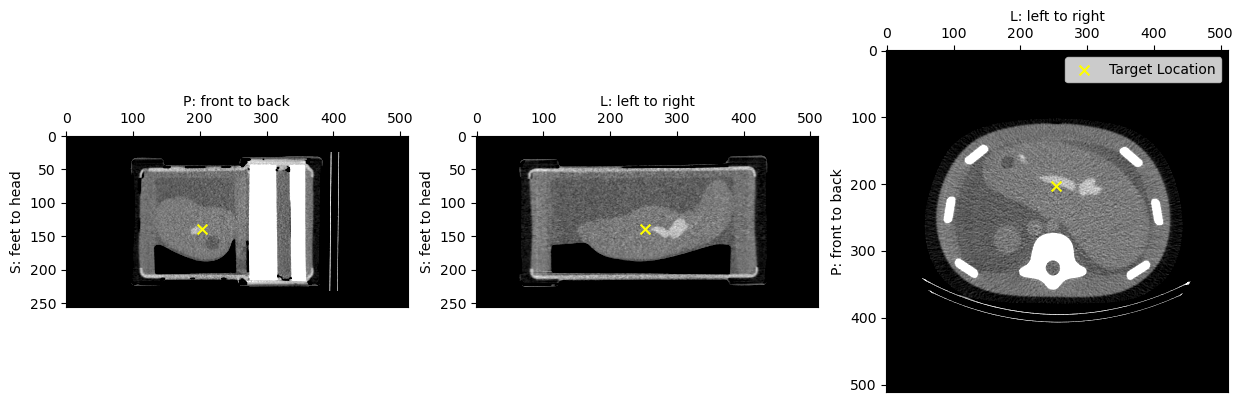

1.0 0.0


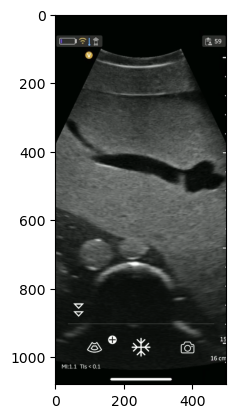

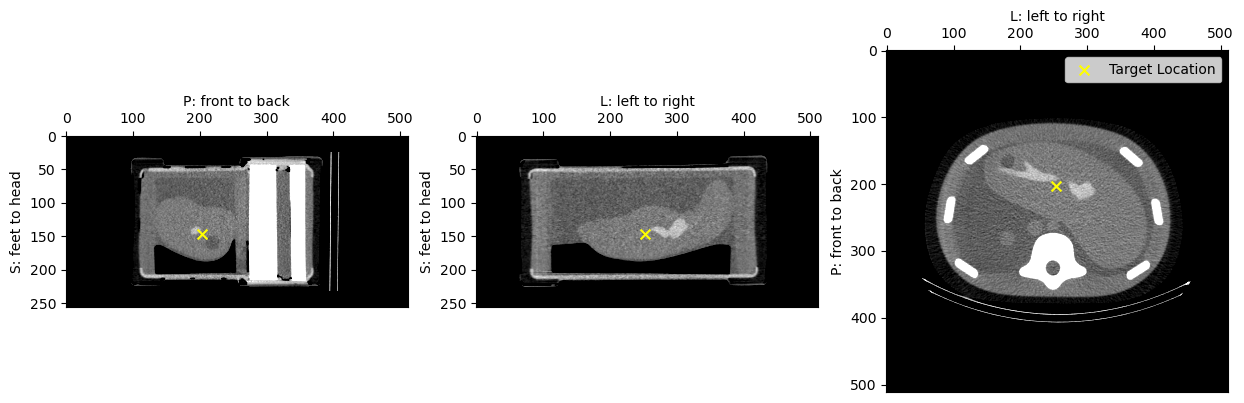

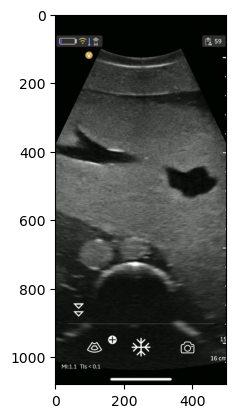

In [31]:

for i in range(len(observations)):
    loc = target_locs[i]

    pix = vessel_ct.TransformPhysicalPointToIndex(loc)
    # visualize_vessel(original_vessel_ct,pix,'Target Location')
    visualize_vessel(body_ct,pix,'Target Location',vmin=0.6,vmax=0.8)

    o = observations[i]
    plt.imshow(o,cmap = 'gray')

# Clean up

In [32]:
# Start the control pipeline
move_default_pose(rtde_c)

In [1]:
ultrasound_vid.release()
pipeline.stop()

NameError: name 'ultrasound_vid' is not defined

# Useful Scripts

In [4]:
# Script for saving default pose
with open('../../config/default_pose.yaml','w') as f:
    yaml.safe_dump({'default_pose':rtde_r.getActualTCPPose()},f)